In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import numpy as np

In [2]:
import glob
calibration_images_dir='../camera_cal'
calibration_images=glob.glob(calibration_images_dir+'/*.jpg')
print("Number of images in calibration directory: {}".format(len(calibration_images)))

Number of images in calibration directory: 20


Found chessboard corners


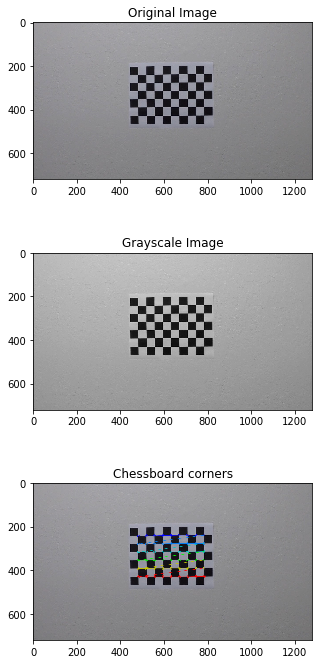

In [9]:
# Read one calibration image and display 
_img_color=cv2.cvtColor(cv2.imread(calibration_images[1]),cv2.COLOR_BGR2RGB)
_img_gray=cv2.cvtColor(_img_color,cv2.COLOR_RGB2GRAY)
# Count chessboard corners (manually done)
nx=9
ny=6
ret,corners=cv2.findChessboardCorners(_img_gray,(nx,ny),None)
fig=plt.figure(figsize=(5,12))
plt.subplot(311)
plt.title("Original Image")
plt.imshow(_img_color)
plt.subplot(312)
plt.title("Grayscale Image")
plt.imshow(_img_gray,cmap='gray')
if ret==True:
    print("Found chessboard corners")
    cv2.drawChessboardCorners(_img_color,(nx,ny),corners,ret)
    plt.subplot(313)
    plt.title("Chessboard corners")
    plt.imshow(_img_color)

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Read all the calibration images and find corners
objectpoints=[]
imagepoints=[]
for calibration_image in calibration_images:
    img_color=cv2.imread(calibration_image)
    img_gray=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    ret,corners=cv2.findChessboardCorners(img_gray,(nx,ny),None)
    if ret == True:
        objectpoints.append(objp)
        corners2=cv2.cornerSubPix(img_gray,corners,(11,11),(-1,-1),criteria)
        imagepoints.append(corners2)        

In [11]:
# Get Calibration Matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, _img_gray.shape[::-1],None,None)

Undistorted Image


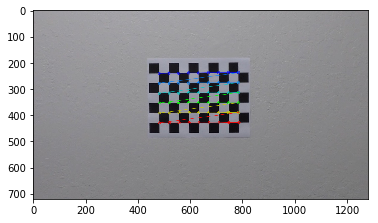

In [12]:
_undistorted_image=cv2.undistort(_img_color,mtx,dist,None,mtx)
print("Undistorted Image")
plt.imshow(_undistorted_image)

Simple function to get undistorted image

In [13]:
def undistort_image(img):
    return cv2.undistort(img,mtx,dist,None,mtx)

In [14]:
# M = cv2.getPerspectiveTransform(src, dst)
# Minv = cv2.getPerspectiveTransform(dst, src)

# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


Gradient Thresholding

In [15]:
image=cv2.imread('../test_images/test3.jpg')
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

In [16]:
# Sobel in X & Y 
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1)
abs_sobelx = np.absolute(sobelx)
# Scaling: Recommended on lecture slide
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

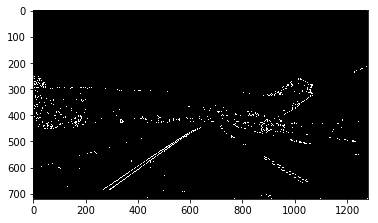

In [24]:
grad_thresh_max=110
grad_thresh_min=30
sxbinary=np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= grad_thresh_min) & (scaled_sobel <= grad_thresh_max)] = 1
plt.imshow(sxbinary,cmap='gray')

In [27]:
# Function to apply Soble - Lecture/Quiz outputs
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [75]:
ksize=11
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 110))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 250))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 150))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.5, 1.2))
combined = np.zeros_like(dir_binary)
combined[((gradx==1)&(grady==1))|((mag_binary==1)&(dir_binary==1))] = 1

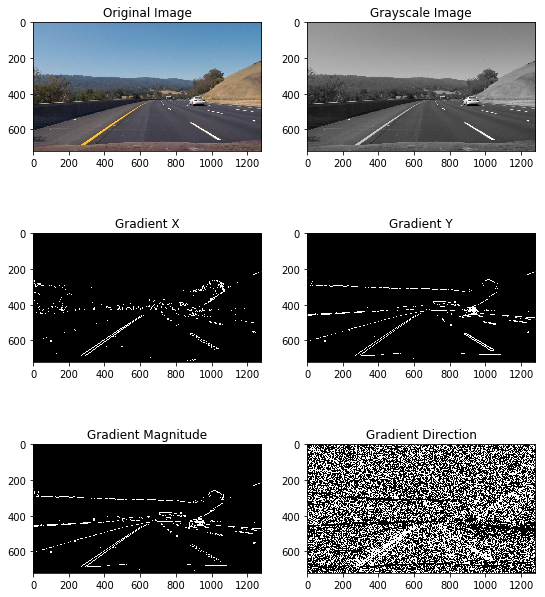

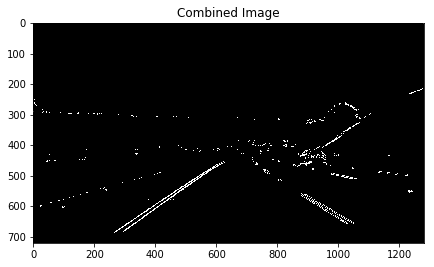

In [76]:
# Plot all the images;
plt.figure(figsize=(9,11))
plt.subplot(321)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.subplot(322)
plt.title("Grayscale Image")
plt.imshow(gray, cmap='gray')
plt.subplot(323)
plt.title("Gradient X")
plt.imshow(gradx,cmap='gray')
plt.subplot(324)
plt.title("Gradient Y")
plt.imshow(grady,cmap='gray')
plt.subplot(325)
plt.title("Gradient Magnitude")
plt.imshow(mag_binary,cmap='gray')
plt.subplot(326)
plt.title("Gradient Direction")
plt.imshow(dir_binary,cmap='gray')

fig=plt.figure(figsize=(7,6))
plt.title("Combined Image")
plt.imshow(combined, cmap='gray')

Color Thresholding

In [77]:
def hls_threshold(img,thresh=(0,255)):
    hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s_channel=hls[:,:,2]
    s_bin=np.zeros_like(s_channel)
    s_bin[(s_channel>=thresh[0])&(s_channel<=thresh[1])] = 1
    return s_bin

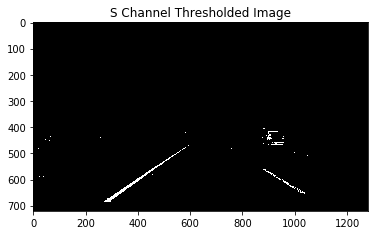

In [80]:
hls_binary=hls_threshold(image,(170,255))
plt.imshow(hls_binary,cmap='gray')
plt.title("S Channel Thresholded Image")

In [81]:
def combine_bin_images(img1,img2):
#     Or operation b/n images
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(img1 == 1) | (img2 == 1)] = 1
    return combined_binary

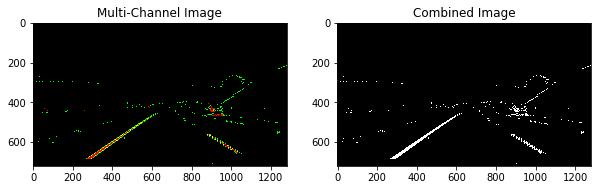

In [82]:
# Show S Channel threshold & Gradient threshold in multi-channel image
_mul_channel=np.dstack((hls_binary,combined,np.zeros_like(hls_binary)))
_combined=combine_bin_images(hls_binary,combined)

fig=plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("Multi-Channel Image")
plt.imshow(_mul_channel)
plt.subplot(122)
plt.title("Combined Image")
plt.imshow(_combined,cmap='gray')